In [1]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import NumPyEigensolver
from qiskit_algorithms.optimizers import COBYLA
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import n_local, efficient_su2, real_amplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms import VQE
from qiskit.providers.fake_provider import GenericBackendV2

In [2]:
# Define the Heisenberg Hamiltonian for a chain of n qubits with coupling Jz
n = 8 # Qubits
Jz = 3 # Coupling strength in the Z direction

# Define the Heisenberg Hamiltonian as a sum of Pauli operators
H = SparsePauliOp.from_list([
    ("XX", 1.0),
    ("YY", 1.0),
    ("ZZ", Jz)
])

def heisenberg_hamiltonian(n_qubits, Jz = 1.0):
    terms = []

    # Add the interaction terms for each pair of neighboring qubits
    for i in range(n_qubits - 1):
        pauli = ["I"] * n_qubits
        pauli[i] = "X"
        pauli[i + 1] = "X"
        terms.append(("".join(pauli), 1.0))

        pauli = ["I"] * n_qubits
        pauli[i] = "Y"
        pauli[i + 1] = "Y"
        terms.append(("".join(pauli), 1.0))

        pauli = ["I"] * n_qubits
        pauli[i] = "Z"
        pauli[i + 1] = "Z"
        terms.append(("".join(pauli), Jz))

    return SparsePauliOp.from_list(terms)

H = heisenberg_hamiltonian(n, Jz)


In [3]:
# Compute the reference ground state energy using a classical eigensolver
numpy_solver = NumPyMinimumEigensolver()
results = numpy_solver.compute_minimum_eigenvalue(H)
ref_val = results.eigenvalue.real # Reference ground state energy
print(f"Reference value: {ref_val}")

Reference value: -24.148682683922583


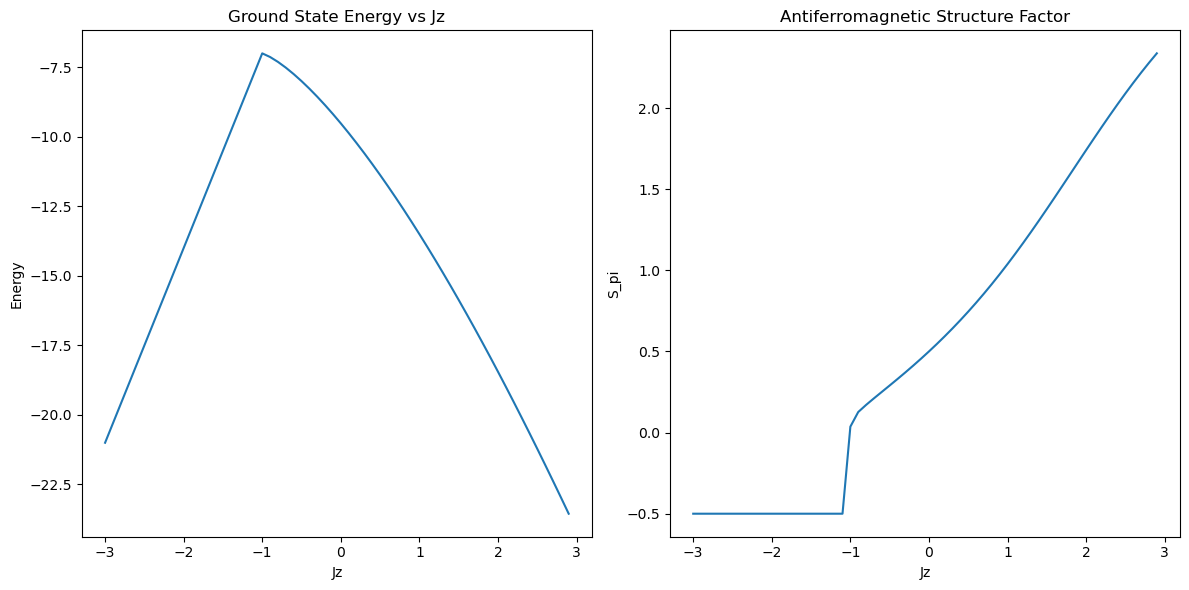

In [4]:
# Using S(pi) operator to compute the antiferromagnetic structure factor
# This is the order parameter for the antiferromagnetic phase
# S(pi) = (1/n) * sum_{i,j} (-1)^(i-j) Z_i Z_j
# This helps find the phase transitions as it gives a non-zero value in the antiferromagnetic phase and zero in the paramagnetic phase

def s_pi_operator(n):
    terms = []

    for i in range(n):
        for j in range(i+1, n):
            pauli = ["I"] * n
            pauli[i] = "Z"
            pauli[j] = "Z"
            coeff = ((-1) ** (i - j)) / n 
            terms.append(("".join(pauli), coeff))

    return SparsePauliOp.from_list(terms)

numpy_solver = NumPyEigensolver(k=2)

J = []
E0 = []
Spi = []

# Precompute the S(pi) operator matrix
s_pi_op_mat = np.array(s_pi_operator(n).to_matrix())

for j in np.arange(-3, 3, 0.1):
    h = heisenberg_hamiltonian(n, Jz = j) # Update the Hamiltonian with the new Jz value
    h_mat = np.array(h.to_matrix()) # Convert the Hamiltonian to a dense matrix for eigensolver

    # Compute the ground state energy and wavefunction using a classical eigensolver
    eigenvalues, eigenvectors = eigh(h_mat) # Use eigh for Hermitian matrices
    e0 = eigenvalues[0]
    psi0 = eigenvectors[:, 0]
    # Compute the expectation value of S(pi) in the ground state
    s_pi = np.real(psi0.conj() @ s_pi_op_mat @ psi0) 
    
    J.append(j)
    E0.append(e0)
    Spi.append(s_pi)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(J, E0, label='Ground State Energy')
plt.xlabel('Jz')
plt.ylabel('Energy')
plt.title('Ground State Energy vs Jz')

plt.subplot(1, 2, 2)
plt.plot(J, Spi, label='S_pi Expectation Value')
plt.xlabel('Jz')
plt.ylabel('S_pi')
plt.title('Antiferromagnetic Structure Factor')
plt.tight_layout()
plt.show()

In the plots above we can see the first phase at Jz = -1. At Jz < -1, The spins align giving us $S(\pi) = 0$, but at -1 we the phase transition with XY phases moving toward the antiferromagnet.

We should see another transition at Jz = +1, known as Berezinskii-Kosterlitz-Thouless (BKT) transition, but doesn't appear as ∆E is continuous. Need larger system to find.

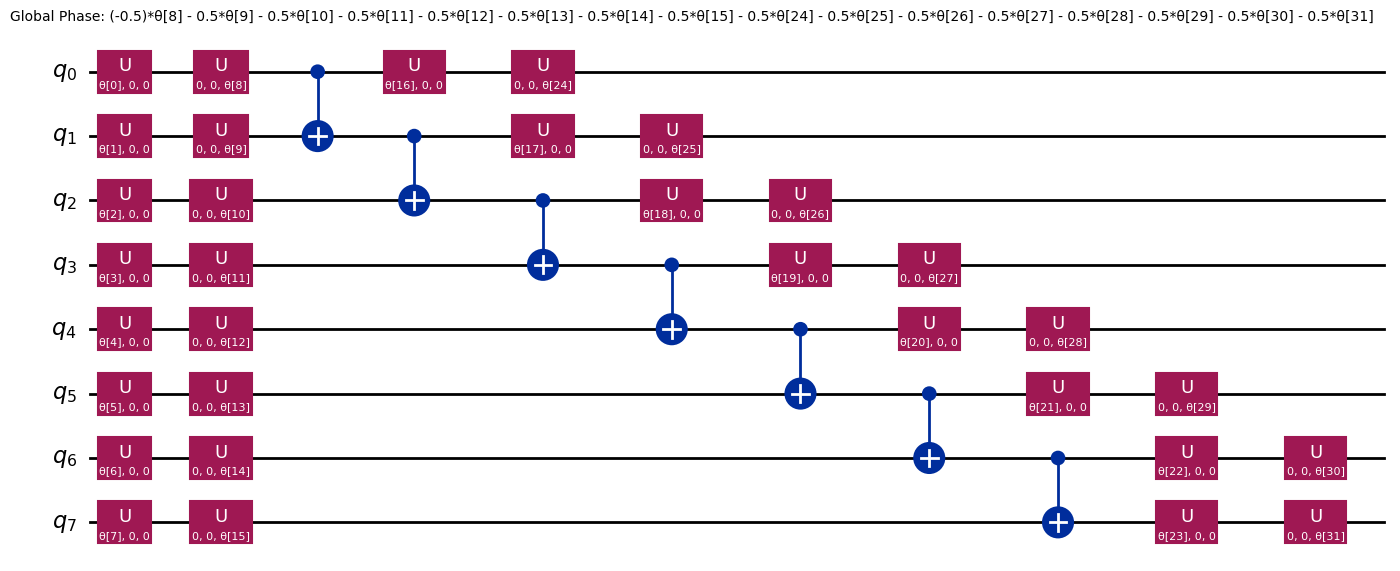

In [5]:
# Now we will use VQE to find the ground state energy and compare it with the reference value
iterations = 300
# We choose efficient SU(2) ansatz that uses minimum gate sets with one repetition
# to keep the circuit depth low (less computation and parameter complexity).
# The linear entanglement was chosen since the Hamiltonian has open boundary conditions, thus it links only neighboring qubits (see coupling map below).
ansatz = efficient_su2(n, entanglement = 'linear', reps = 1).decompose() 
# SPSA is a gradient-free optimizer that perturbs all parameters and measures energy changes. 
# It is efficient for noisy quantum devices and can handle many parameters. 
spsa = SPSA(maxiter=iterations)
ansatz.decompose().draw('mpl')

In [6]:
# Here we define a callback function to store the intermediate results of the VQE optimization process.
counts = []
values = []
counts_noisy = []
values_noisy = []

# One for noiseless simulator and one for noisy simulator to compare the results.
def store_noiseless_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

def store_noisy_intermediate_result(eval_count, parameters, mean, std):
    counts_noisy.append(eval_count)
    values_noisy.append(mean)
    

In [7]:
seed = 64 # Set a fixed random seed for reproducibility of results

algorithm_globals.random_seed = seed

noiseless_estimator = StatevectorEstimator() # Use the statevector simulator for noiseless estimation

# Coupling map for a linear chain of 8 qubits (open boundary conditions)
coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]]


# Use a real noise model after making IBM Quantum account
# service = QiskitRuntimeService()
# real_backend = service.backend("ibm_heron")
# noise_model = NoiseModel.from_backend(real_backend)
# aer_sim = AerEstimator(noise_model=noise_model, coupling_map=coupling_map)

# Since we don't have access to a real backend, we will use a fake backend to generate a noise model that mimics the noise characteristics of a real quantum device. 
device = GenericBackendV2(num_qubits = n, coupling_map = coupling_map, seed = seed)

noise_model = NoiseModel.from_backend(device)

noisy_estimator = AerEstimator(
    options = {
        "default_precision": 1e-2,
        "backend_options": {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "noise_model": noise_model
        }
    }
)

In [8]:
# Run VQE with both noiseless and noisy estimators and store the intermediate results using the callback functions defined above.
vqe_noiseless = VQE(noiseless_estimator, ansatz, spsa, callback = store_noiseless_intermediate_result)
results_noiseless = vqe_noiseless.compute_minimum_eigenvalue(H)

vqe_noisy = VQE(noisy_estimator, ansatz, spsa, callback = store_noisy_intermediate_result)
results_noisy = vqe_noisy.compute_minimum_eigenvalue(H)

print(f"Noiseless VQE result: {results_noiseless.eigenvalue.real}")
print(f"Delta from reference: {results_noiseless.eigenvalue.real - ref_val}")
print(f"Noisy VQE result: {results_noisy.eigenvalue.real}")
print(f"Delta from reference: {results_noisy.eigenvalue.real - ref_val}")

Noiseless VQE result: -21.960622343335302
Delta from reference: 2.188060340587281
Noisy VQE result: -21.87136797462898
Delta from reference: 2.277314709293602


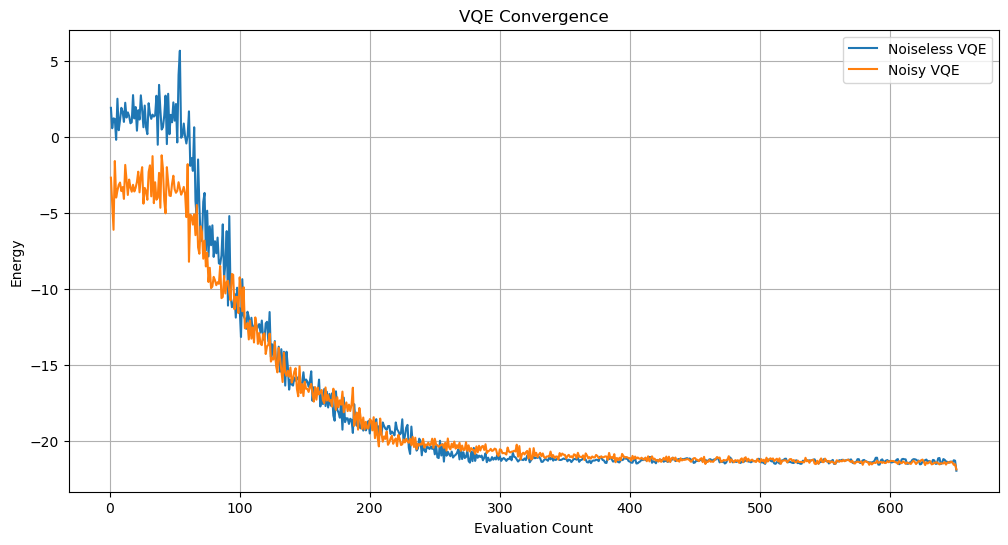

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(counts, values, label='Noiseless VQE')
plt.plot(counts_noisy, values_noisy, label='Noisy VQE')
plt.xlabel('Evaluation Count')
plt.ylabel('Energy')
plt.title('VQE Convergence')
plt.grid()
plt.legend()
plt.show()

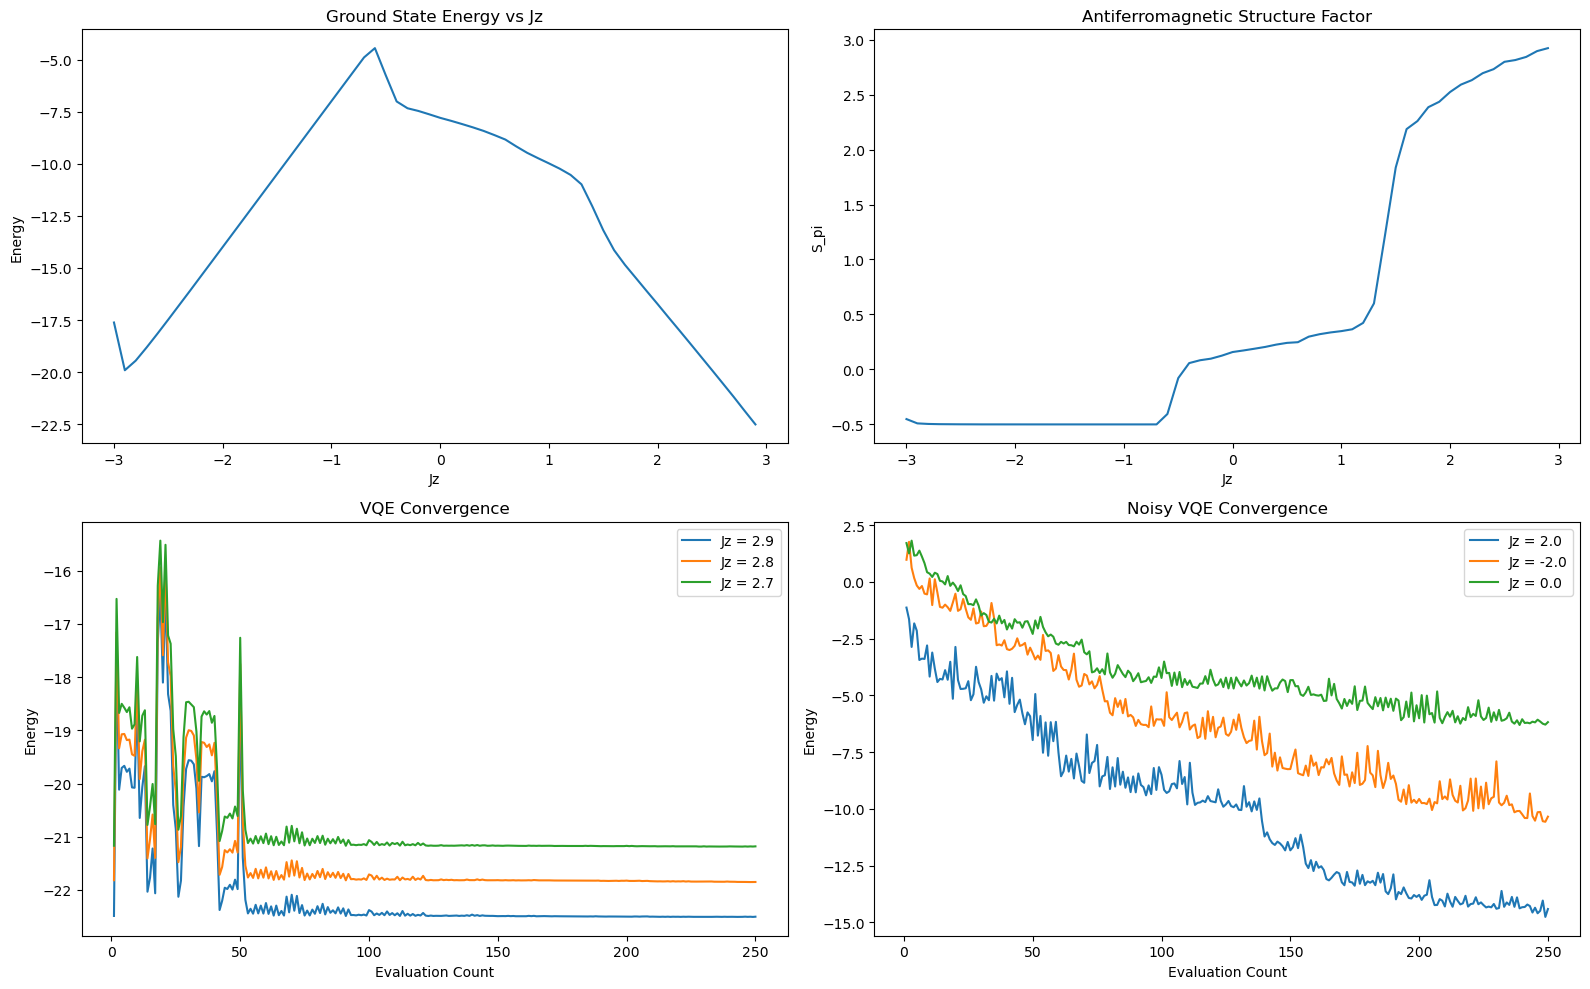

In [10]:
# Now we will run VQE for a range of Jz values and store the intermediate results for each run to analyze the convergence behavior across different parameter regimes.
# We also increase the repetitions of the ansatz to 2 to allow for better expressibility and potentially better convergence, especially in the presence of noise.

# Clear the previous results to store new ones for the range of Jz values
counts.clear(); values.clear()
counts_noisy.clear(); values_noisy.clear()

all_counts, all_values = [], []
all_counts_noisy, all_values_noisy = [], []

# This callback function will store the intermediate results for each run of VQE with different Jz values. 
# It appends the evaluation counts and energy values to separate lists for each run, allowing us to analyze the convergence behavior across different parameter regimes.

def store_noiseless_intermediate_result(eval_count, parameters, mean, std):
    if eval_count == 1:
        all_counts.append([])
        all_values.append([])
    all_counts[-1].append(eval_count) #
    all_values[-1].append(mean)
    counts.append(eval_count)
    values.append(mean)


def store_noisy_intermediate_result(eval_count, paramters, mean, std):
    if eval_count == 1:
        all_counts_noisy.append([])
        all_values_noisy.append([])
    all_counts_noisy[-1].append(eval_count)
    all_values_noisy[-1].append(mean)
    counts_noisy.append(eval_count)
    values_noisy.append(mean)

# We swapped the optimizer to COBYLA for this part of the analysis to see how a different optimization algorithm performs across a range of Jz values, especially in the presence of noise.
optimizer = COBYLA(maxiter=250)
# Increased the repetitions to 2
ansatz = efficient_su2(n, entanglement = 'linear', reps = 2).decompose()

vqe_noiseless = VQE(noiseless_estimator, ansatz, optimizer, callback = store_noiseless_intermediate_result)
vqe_noisy = VQE(noisy_estimator, ansatz, optimizer, callback = store_noisy_intermediate_result)

J, E0, Spi = [], [], []

# We will use the optimal parameters from the previous run as the initial point for the next run to potentially improve convergence, especially in the presence of noise.
opt_params = None

for j in np.arange(-3, 3, 0.1):
    H = heisenberg_hamiltonian(n, Jz = j)


    if opt_params is not None:
        vqe_noiseless.initial_point = opt_params
    
    results = vqe_noiseless.compute_minimum_eigenvalue(H)
    opt_params = results.optimal_point

    # Compute the expectation value of S(pi) using the optimal parameters found by VQE
    prim = noiseless_estimator.run(
        [(ansatz, s_pi_operator(n), opt_params)]
    ).result()

    # Store the results for plotting
    J.append(j)
    E0.append(float(np.real(results.eigenvalue)))  # Store the best energy found by VQE for the current Jz value
    Spi.append(float(np.real(prim[0].data.evs)))  # Extract the expectation value from the result


# For noisy analysis, we will run VQE for a few selected Jz values to see how the noise affects the convergence and the final energy values.
# It is very computationally expensive to run VQE for a large range of Jz values with noise, so we will focus on a few key points around the expected phase transition region to analyze the impact of noise on the optimization process and the resulting energy values.
noisy_spot_j = [-2, 0, 2]
noisy_spot_e = []

for j in noisy_spot_j:
    H = heisenberg_hamiltonian(n, Jz = j)
    results_noisy = vqe_noisy.compute_minimum_eigenvalue(H)
    noisy_spot_e.append(float(np.real(results_noisy.eigenvalue))) 

# Here we will analyze the convergence behavior of the VQE optimization process across different runs by looking at the minimum energy values achieved in each run 
# and comparing them to identify which runs had the best convergence towards the ground state energy.

run_mins = sorted(enumerate(all_values), key=lambda x: min(x[1]))
best_runs = run_mins[:3]

noisy_mins = sorted(range(len(all_values_noisy)),
                    key=lambda i: min(all_values_noisy[i]))[:3]


plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(J, E0, label='Ground State Energy')
plt.xlabel('Jz')
plt.ylabel('Energy')
plt.title('Ground State Energy vs Jz')

plt.subplot(2, 2, 2)
plt.plot(J, Spi, label='S_pi Expectation Value')
plt.xlabel('Jz')
plt.ylabel('S_pi')
plt.title('Antiferromagnetic Structure Factor')

plt.subplot(2, 2, 3)
for i, _ in best_runs:
        plt.plot(all_counts[i], all_values[i], label = f"Jz = {J[i]:.1f}")
plt.xlabel('Evaluation Count')
plt.ylabel('Energy')
plt.title('VQE Convergence')
plt.legend()

plt.subplot(2, 2, 4)
for idx, i in enumerate(noisy_mins):
        plt.plot(all_counts_noisy[i], all_values_noisy[i], label = f"Jz = {noisy_spot_j[i]:.1f}")
plt.xlabel('Evaluation Count')
plt.ylabel('Energy')
plt.title('Noisy VQE Convergence')
plt.legend()

plt.tight_layout()
plt.show()

The results show that the lowest states are at the boundary conditions (noiseless). The peaks at the beginning are where the VQE is exploring until it converges to its groundstate. The reason why each run gets lower is due to the 'warm up', using previous optimal parameters to help with future runs. For the noisy VQE, the three different curves show the energy landscapes at different phases.

The optimizer COBYLA outperformed SPSA when increasing the repetitions of the ansatz drastically with converging in much fewer iterations.

Running VQE with EfficientSU2 ansatz...(48 parameters)
EfficientSU2 done. Final delta from reference: 0.7296261158303103
Running VQE with RealAmplitudes ansatz...(24 parameters)
RealAmplitudes done. Final delta from reference: 0.9403505810403203
Running VQE with NLocal ansatz...(48 parameters)
NLocal done. Final delta from reference: 1.753181566149344


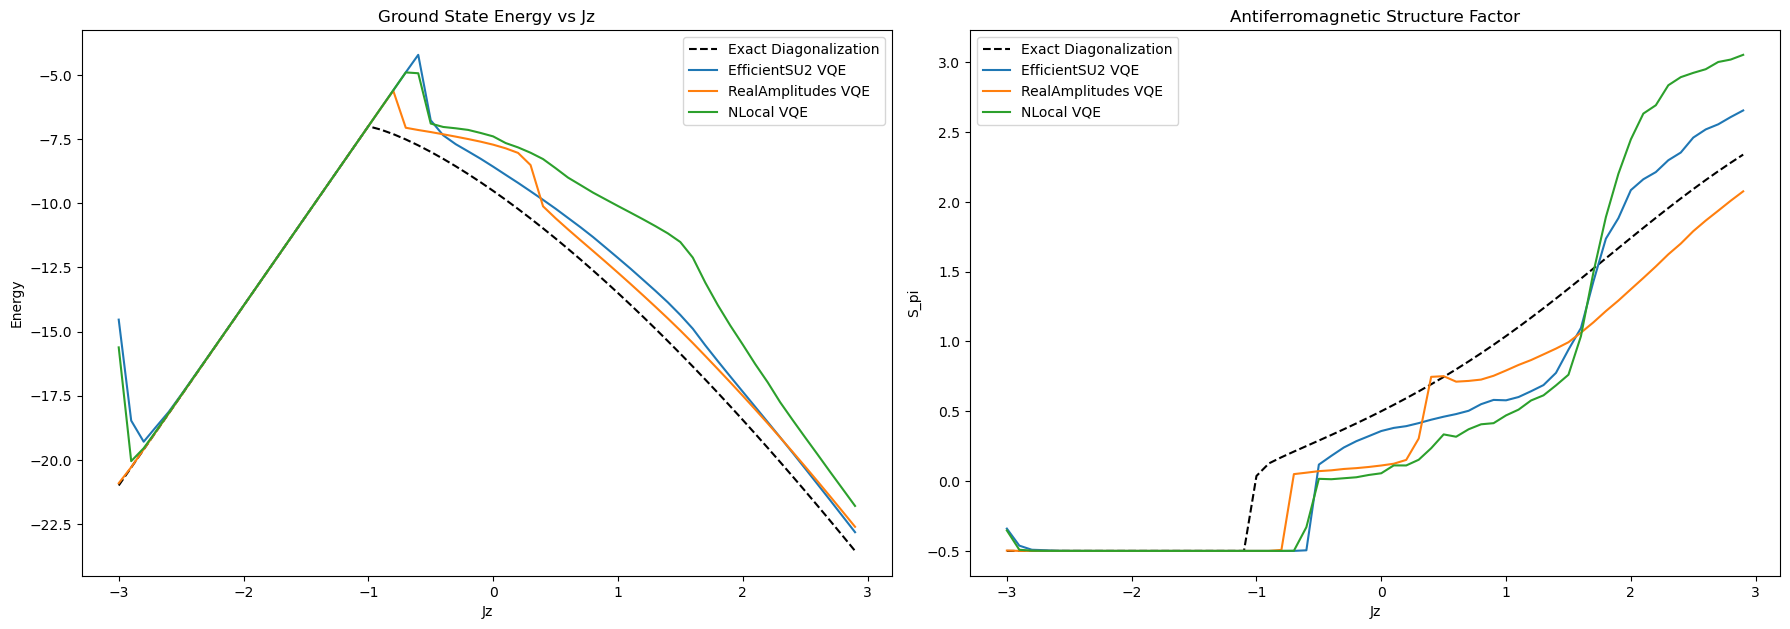

In [11]:
# Now we'll look at comparing different ansatz (not just efficient_su2).

# Exact diagonalization for reference
J_exact, E0_exact, Spi_exact = [], [], []
s_pi_matrix = np.array(s_pi_operator(n).to_matrix())

for j in np.arange(-3, 3, 0.1):
    h_mat = np.array(heisenberg_hamiltonian(n, Jz = j).to_matrix())
    eigenvalues, eigenvectors = eigh(h_mat)
    psi0 = eigenvectors[:, 0]
    J_exact.append(j)
    E0_exact.append(eigenvalues[0])
    Spi_exact.append(np.real(psi0.conj() @ s_pi_matrix @ psi0))

# Define different ansatz to compare
ansatzes = {
    "EfficientSU2": efficient_su2(n, entanglement='linear', reps=2).decompose(),
    "RealAmplitudes": real_amplitudes(n, entanglement='linear', reps=2).decompose(),
    "NLocal": n_local(n, reps=2, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz').decompose()
}

optimizer = COBYLA(maxiter=250)

results_dict = {}

# Run VQE for each ansatz and store the results for comparison. We will use the optimal parameters from the previous run as the initial point for the next run to potentially improve convergence, especially in the presence of noise.
for name, ansatz in ansatzes.items():
    print(f"Running VQE with {name} ansatz...({ansatz.num_parameters} parameters)")

    vqe = VQE(noiseless_estimator, ansatz, optimizer, callback = store_noiseless_intermediate_result)

    J, E0, Spi = [], [], []
    opt_params = None

    for j in np.arange(-3, 3, 0.1):
        H = heisenberg_hamiltonian(n, Jz = j)

        if opt_params is not None:
            vqe.initial_point = opt_params
        
        results = vqe.compute_minimum_eigenvalue(H)
        opt_params = results.optimal_point

        prim = noiseless_estimator.run(
            [(ansatz, s_pi_operator(n), opt_params)]
        ).result()

        J.append(j)
        E0.append(float(np.real(results.eigenvalue)))
        Spi.append(float(np.real(prim[0].data.evs)))
    
    results_dict[name] = (J, E0, Spi)
    print(f"{name} done. Final delta from reference: {E0[-1] - E0_exact[-1]}")

plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.plot(J_exact, E0_exact, label='Exact Diagonalization', color='black', linestyle='--')
for name, (J, E0, Spi) in results_dict.items():
    plt.plot(J, E0, label=f'{name} VQE')
plt.xlabel('Jz')
plt.ylabel('Energy')
plt.title('Ground State Energy vs Jz')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(J_exact, Spi_exact, label='Exact Diagonalization', color='black', linestyle='--')
for name, (J, E0, Spi) in results_dict.items():
    plt.plot(J, Spi, label=f'{name} VQE')
plt.xlabel('Jz')
plt.ylabel('S_pi')
plt.title('Antiferromagnetic Structure Factor')
plt.legend()

plt.tight_layout()
plt.show()